In [30]:
import numpy as np
import gc
import os
import time
import sklearn.preprocessing

from helpers import *

global result_dir

hnsw_best_params_all_data = {'mnist': {'M': 64, 'efConstruction': 500},
                            'glove': {'M': 96, 'efConstruction': 500},
                            'deep': {'M': 96, 'efConstruction': 500},
                            'sift': {'M': 96, 'efConstruction': 500},
                            }

def build_hnsw_tuned(data, dim, metric, params):
    hnsw_index = initialize_hnsw(dim, metric) # hnswlib only support l2 distance
    # hnsw_index.init_index(max_elements=len(data), ef_construction = 200, M = 16)
    hnsw_index.init_index(max_elements=len(data), ef_construction=params['efConstruction'], M=params['M'])
    hnsw_index.add_items(data)

    return hnsw_index

class ANNHNSWTuned:
    def __init__(self, dataset_name, k, metric, hnsw_best_params, result_dir):
        self.dataset_name = dataset_name
        self.k = k
        self.metric = metric
        self.result_dir = result_dir
        self.results = {}

        self.train, self.test, self.dim = load_and_transform_dataset(self.dataset_name)
        if self.metric == 'cosine':
            self.train = sklearn.preprocessing.normalize(self.train, axis=1, norm="l2")
            self.test = sklearn.preprocessing.normalize(self.test, axis=1, norm="l2")

        print("Dataset Loaded")
        print("="*21)
        self.filename = dataset_name.split('-')[0]
        self.hnsw_best_params = hnsw_best_params[self.filename]
        
        # brute force ground truth
        print('Loading Brute Force')
        self.brute = brute_load_index(f'brute_index_{self.filename}', self.dim, self.metric, self.result_dir)
        self.brute_labels = load_exported_results(f"brute_labels_{self.filename}", self.result_dir)
        self.brute_dist = load_exported_results(f"brute_dist_{self.filename}", self.result_dir)
        
    def run_experiment(self):

        # hnsw
        print('Running HNSW')
        
        start = time.time()
        hnsw_tuned = build_hnsw_tuned(self.train, self.dim, metric='l2', params=self.hnsw_best_params)

        hnsw_tuned_build_time = time.time() - start
        print(f'hnsw_tuned Build Time: {hnsw_tuned_build_time} seconds')

        start = time.time()
        hnsw_tuned_labels, hnsw_tuned_dist = run_hnsw(hnsw_tuned, self.test, self.k)
        hnsw_tuned_query_time = time.time() - start
        print(f'hnsw_tuned Query Time: {hnsw_tuned_query_time} seconds')

        hnsw_tuned_recall = np.mean(recall(hnsw_tuned_labels, self.brute_labels))
        print(f'hnsw_tuned Recall: {hnsw_tuned_recall}')
        print("="*21)

        self.results['hnsw_tuned'] = {}
        self.results['hnsw_tuned']['recall'] = hnsw_tuned_recall
        self.results['hnsw_tuned']['build_time'] = hnsw_tuned_build_time
        self.results['hnsw_tuned']['query_time'] = hnsw_tuned_query_time

        hnsw_export_index(hnsw_tuned, f"hnsw_tuned_index_{self.filename}", self.result_dir)
        export_to_hdf5(hnsw_tuned_labels, f"hnsw_tuned_labels_{self.filename}", f"hnsw_tuned_labels_{self.filename}", self.result_dir)
        export_to_hdf5(hnsw_tuned_dist, f"hnsw_tuned_dist_{self.filename}", f"hnsw_tuned_dist_{self.filename}", self.result_dir)

In [9]:
hnsw_tuned_result_dict = {}

In [12]:
dataset_name = 'sift-128-euclidean'
k = 10
metric = 'l2' # l2 or angular --> for annoy have condition to change the name already
result_dir = './result/sift'
os.makedirs(result_dir, exist_ok=True)

exp = ANNHNSWTuned(dataset_name, k, metric, hnsw_best_params_all_data, result_dir)
exp.run_experiment()

# get accuracy results
hnsw_tuned_result_dict['sift'] = exp.results
exp.results

Got a train set of size (1000000 * 128)
Got 10000 queries
Dataset Loaded
Loading Brute Force
Running HNSW
hnsw_tuned Build Time: 490.23624992370605 seconds
hnsw_tuned Query Time: 0.29738807678222656 seconds
hnsw_tuned Recall: 0.8235299999999999


{'hnsw_tuned': {'recall': 0.8235299999999999,
  'build_time': 490.23624992370605,
  'query_time': 0.29738807678222656}}

In [13]:
dataset_name = 'glove-100-angular'
k = 10
metric = 'cosine' # l2 or cosine
result_dir = './result/glove'
os.makedirs(result_dir, exist_ok=True)

exp = ANNHNSWTuned(dataset_name, k, metric, hnsw_best_params_all_data, result_dir)
exp.run_experiment()

# get accuracy results
hnsw_tuned_result_dict['glove'] = exp.results
exp.results

Got a train set of size (1183514 * 100)
Got 10000 queries
Dataset Loaded
Loading Brute Force
Running HNSW
hnsw_tuned Build Time: 1511.0596585273743 seconds
hnsw_tuned Query Time: 0.5713100433349609 seconds
hnsw_tuned Recall: 0.66635


{'hnsw_tuned': {'recall': 0.66635,
  'build_time': 1511.0596585273743,
  'query_time': 0.5713100433349609}}

In [31]:
dataset_name = 'deep-image-96-euclidean'
k = 10
metric = 'l2' # l2 or angular --> for annoy have condition to change the name already
result_dir = './result/deep'
os.makedirs(result_dir, exist_ok=True)

exp = ANNHNSWTuned(dataset_name, k, metric, hnsw_best_params_all_data, result_dir)
exp.run_experiment()

# get accuracy results
hnsw_tuned_result_dict['deep'] = exp.results
exp.results

Got a train set of size (1000000 * 96)
Got 10000 queries
Dataset Loaded
Loading Brute Force
Running HNSW
hnsw_tuned Build Time: 440.2416741847992 seconds
hnsw_tuned Query Time: 0.2549624443054199 seconds
hnsw_tuned Recall: 0.8231200000000001


{'hnsw_tuned': {'recall': 0.8231200000000001,
  'build_time': 440.2416741847992,
  'query_time': 0.2549624443054199}}

In [15]:
dataset_name = 'mnist-784-euclidean'
k = 10
metric = 'l2' # l2 or angular --> for annoy have condition to change the name already
result_dir = './result/mnist'
os.makedirs(result_dir, exist_ok=True)

exp = ANNHNSWTuned(dataset_name, k, metric, hnsw_best_params_all_data, result_dir)
exp.run_experiment()

# get accuracy results
hnsw_tuned_result_dict['mnist'] = exp.results
exp.results

Got a train set of size (60000 * 784)
Got 10000 queries
Dataset Loaded
Loading Brute Force
Running HNSW
hnsw_tuned Build Time: 31.10383129119873 seconds
hnsw_tuned Query Time: 0.41745567321777344 seconds
hnsw_tuned Recall: 0.9471800000000001


{'hnsw_tuned': {'recall': 0.9471800000000001,
  'build_time': 31.10383129119873,
  'query_time': 0.41745567321777344}}

In [32]:
hnsw_tuned_result_dict

{'sift': {'hnsw_tuned': {'recall': 0.8235299999999999,
   'build_time': 490.23624992370605,
   'query_time': 0.29738807678222656}},
 'glove': {'hnsw_tuned': {'recall': 0.66635,
   'build_time': 1511.0596585273743,
   'query_time': 0.5713100433349609}},
 'deep': {'hnsw_tuned': {'recall': 0.8231200000000001,
   'build_time': 440.2416741847992,
   'query_time': 0.2549624443054199}},
 'mnist': {'hnsw_tuned': {'recall': 0.9471800000000001,
   'build_time': 31.10383129119873,
   'query_time': 0.41745567321777344}}}

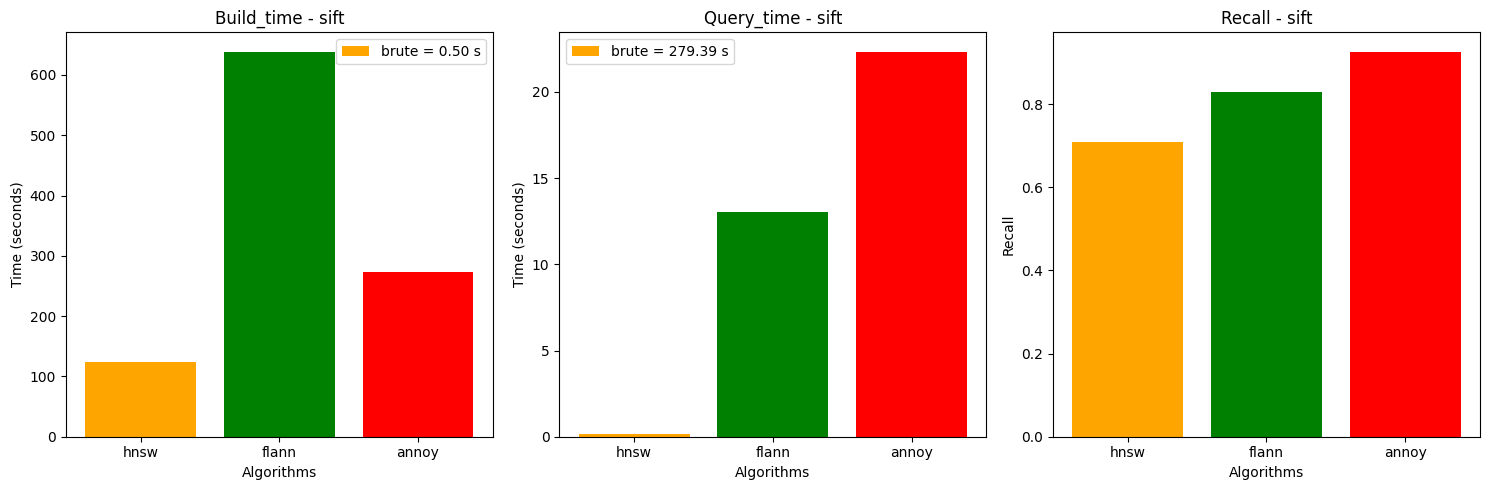

In [3]:
import matplotlib.pyplot as plt

def plot_metrics(dataset_name, results):
    algorithms = results[dataset_name]
    metrics = ['build_time', 'query_time', 'recall']
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, metric in enumerate(metrics):
        values = [algorithms[algo][metric] for algo in algorithms if algo != 'brute']
        algorithm_names = [algo for algo in algorithms if algo != 'brute']

        # Plot the metric for each algorithm
        axes[i].bar(algorithm_names, values, color=['orange', 'green', 'red'])
        
        # Add 'brute' result to the legend
        if 'brute' in algorithms and metric != 'recall':
            brute_value = algorithms['brute'][metric] 
            axes[i].legend(['brute = {:.2f} s'.format(brute_value)])

        axes[i].set_title(f'{metric.capitalize()} - {dataset_name}')
        axes[i].set_ylabel('Time (seconds)' if 'time' in metric else metric.capitalize())
        axes[i].set_xlabel('Algorithms')

    plt.tight_layout()
    plt.show()

# Example usage for one dataset (e.g., 'deep')
dataset_name = 'sift'
plot_metrics(dataset_name, all_data_result_dict)

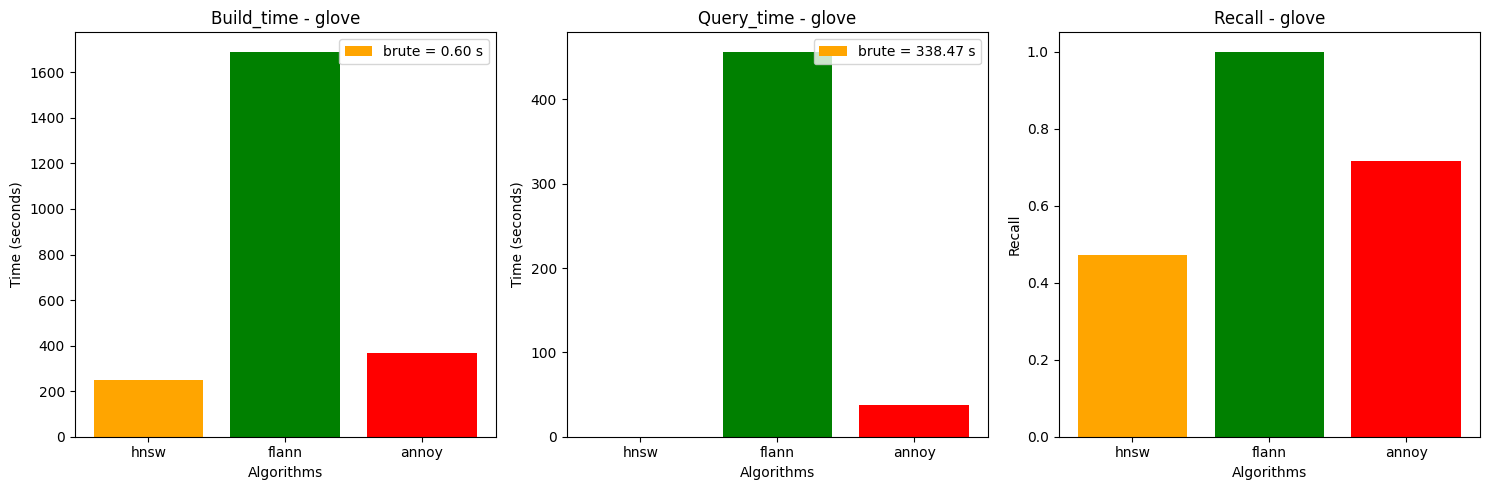

In [4]:
# Example usage for one dataset (e.g., 'deep')
dataset_name = 'glove'
plot_metrics(dataset_name, all_data_result_dict)

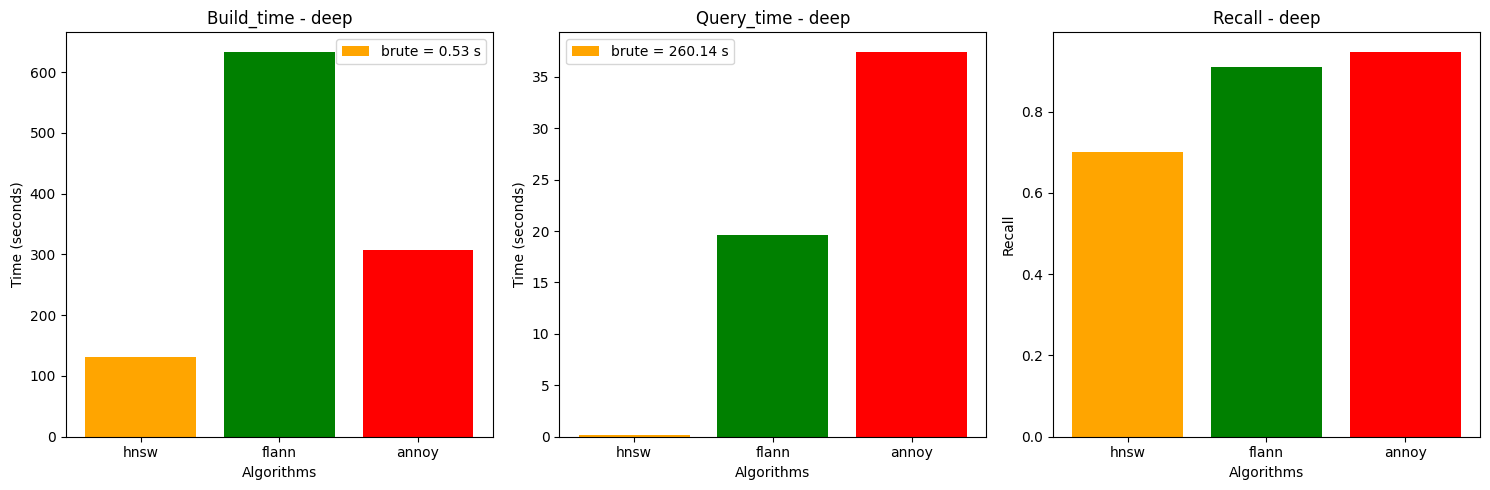

In [5]:
dataset_name = 'deep'
plot_metrics(dataset_name, all_data_result_dict)

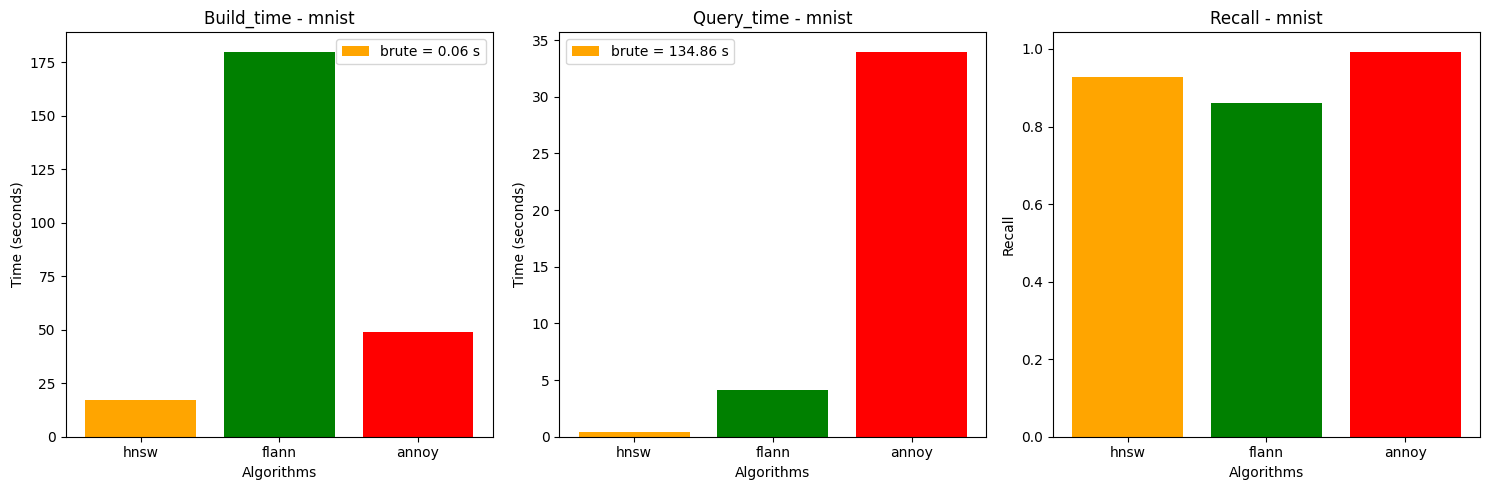

In [6]:
dataset_name = 'mnist'
plot_metrics(dataset_name, all_data_result_dict)